In [1]:
import torch

## 1. Simplified Attention

Say we want to compute self-attention output for 2nd token `x^2` in position, which is `journey`

### 1.1. Sample Toy Input

Word embedding are made to be just 3D dimensional

In [2]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

### 1.2. Steps

#### 1.2.1. Computing Attention Scores

Dot Product operation is used mathematically represent how two vectors are aligned
> Dot Product of query `x^2` with every other token in sequence

In [3]:
query = inputs[1]

attn_scores_2 = torch.empty(inputs.shape[0])

for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(query, x_i)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


#### 1.2.2. Normalise Attention Scores

* Main Goal behind the normalization to obtain attention weights which can sum to 1

* It makes it use full for convention and interpretation

We use softmax instead of summation function as it offers

* Positive Values -> Probability
* Favorable Gradient Properties

##### 1.2.2.1. Summation Normalisation [NOT USED]

In [4]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


##### 1.2.2.2. Softmax Normalisation

In [5]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())


## using pytorch inbuilt softmax function
attn_weights_2 = torch.nn.functional.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())



Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


#### 1.2.3. Updated Context Vector

This final step, updates initial context vector of `x^2` using attention weights derived in previous steps

In [6]:
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


### 1.3. Matrix Form

#### 1.3.1. Attention scores

In [7]:
## for loops which is slower

attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [8]:
## matrix multiplication which is faster
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


#### 1.3.2. Attention weights

In [9]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [10]:
attn_weights.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

#### 1.3.3. Updated Context Vector

In [11]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


## 2. Self Attention [Q,K,V]

This form of self attention is used in Transformer architectures. let's start with same Toy Input

On a high level, self attention is way to update input token embeddings to account for context in the sequence. For Example, let's consider 3 Individual words

### 2.1. Single Input

In [12]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

### 2.2. Defining Query, Key and Value Matrix



In [13]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

### 2.3. Computing Q,K,V for Input Token

In [14]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


### 2.4. Key & Value for all tokens

In [15]:
keys = inputs @ W_key
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


### 2.5. Computing Attention Scores

Let `D` be dimension of Q, K, V projection matrices and `N` be sequence length, with Embedding being `P` dimensional


Query: Query Vector Of Input Token in Sequence: (1, D)
Keys: Key Vector Of all tokens in Sequence: (N, D)
Values: Value Vector for all tokens in Sequence: (N, D)

Attention_score = (1, D) dot (N, D) --> (N, 1)

In [16]:
attn_score_2 = query_2 @ keys.T
print("attn_score_2:", attn_score_2)

attn_score_2: tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


### 2.6. Scaling Attention Scores

Let $d_k$ be dimension of key vector and query vector (both have to be same), so when we take dot product

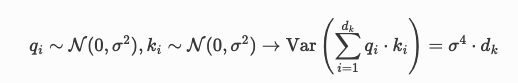



Attention score would now have variance of $\sigma^4 . d_k$, In order stablise variance so that it is approximately 1 thorughout the model, attention score is divided by $ \sqrt{d_k} $ 

> Note: $ \sigma^4$ is ignored as it around 1

In [17]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_score_2 / (d_k ** 0.5), dim=-1)
print("attn_weights_2:", attn_weights_2)

attn_weights_2: tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


### 2.7. Updating Context Vector

In [18]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


## 3. PyTorch Implementaion

In [19]:
import torch.nn as nn

### 3.1. Using nn.Paramter for Q, K, V Weight matrix

In [20]:
from functools import wraps

def toggle_transpose(fn):
    @wraps(fn)
    def wrapper(self, x, transpose_qkv=False):
        return fn(self, x, transpose_qkv)
    return wrapper

In [21]:
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    @toggle_transpose
    def forward(self, x, transpose_qkv=False):

        keys = x @ (self.W_key.T if transpose_qkv else self.W_key)
        queries = x @ (self.W_query.T if transpose_qkv else self.W_query)
        values = x @ (self.W_value.T if transpose_qkv else self.W_value)
        
        d = keys.shape[1]

        attn_scores = queries @ keys.T
        scaled_attn_scores = attn_scores / (d ** 0.5)
        attn_weights = torch.softmax(scaled_attn_scores, dim=-1)

        context_vec = attn_weights @ values

        return context_vec

In [22]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


### 3.2. Using nn.Linear Object

In [23]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=False)
        self.W_key = nn.Linear(d_in, d_out, bias=False)
        self.W_value = nn.Linear(d_in, d_out, bias=False)

    def forward(self, x):

        query = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        d = keys.shape[1]

        attn_scores = query @ keys.T
        attn_scores_scaled = attn_scores / (d ** 0.5)
        attn_weights = torch.softmax(attn_scores_scaled, dim=-1)

        context_vec = values.T @ attn_weights

        return context_vec.T

In [24]:
W_query = nn.Linear(d_in, d_out, bias=False)
W_key = nn.Linear(d_in, d_out, bias=False)
W_value = nn.Linear(d_in, d_out, bias=False)

In [25]:
queries = W_query(inputs)
keys = W_key(inputs)
values = W_value(inputs)

d_k = keys.shape[1]
attn_scores = queries @ keys.T
attn_scores_scaled = attn_scores / (d_k ** 0.5)
attn_weights = torch.softmax(attn_scores_scaled, dim=-1)

context_vec = attn_weights @ values

In [26]:
context_vec = values.T @ attn_weights
context_vec.T

tensor([[0.4311, 0.2921],
        [0.5222, 0.3526],
        [0.5234, 0.3534],
        [0.5183, 0.3503],
        [0.5370, 0.3624],
        [0.5069, 0.3429]], grad_fn=<PermuteBackward0>)

In [27]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0925,  0.0751],
        [-0.0767,  0.0664],
        [-0.0769,  0.0664],
        [-0.0701,  0.0624],
        [-0.0776,  0.0663],
        [-0.0691,  0.0620]], grad_fn=<PermuteBackward0>)


In [28]:
sa_v2.W_query.weight

Parameter containing:
tensor([[ 0.3161,  0.4568,  0.5118],
        [-0.1683, -0.3379, -0.0918]], requires_grad=True)

In [29]:
torch.manual_seed(789)
sa_v1 = SelfAttention_v1(d_in, d_out)

In [30]:
sa_v1.W_query = sa_v2.W_query.weight
sa_v1.W_key = sa_v2.W_key.weight
sa_v1.W_value = sa_v2.W_value.weight

print(sa_v1(inputs, transpose_qkv=True))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


## 4. Causal Attention

Causal self-attention is needed primarily in autoregressive tasks, such as language modeling, where the model generates tokens sequentially and must not “see” future tokens when predicting the next one.

Why is it needed?

1.	Prevents Information Leakage:

	•	In tasks like text generation, the model should not have access to words it has not yet generated.
	
    •	Without causal masking, the attention mechanism would use future words, leading to data leakage and unrealistic training behavior.

2.	Ensures Autoregressive Decoding:
	
    •	Many models, like GPT, generate text token-by-token.
	
    •	If attention considered future tokens, the model would learn an unrealistic dependency structure.

3.	Aligns Training and Inference:
	
    •	During training, all tokens are available at once, but during inference, the model generates words one at a time.
	
    •	Causal masking forces the model to only rely on past tokens, mimicking inference conditions.

    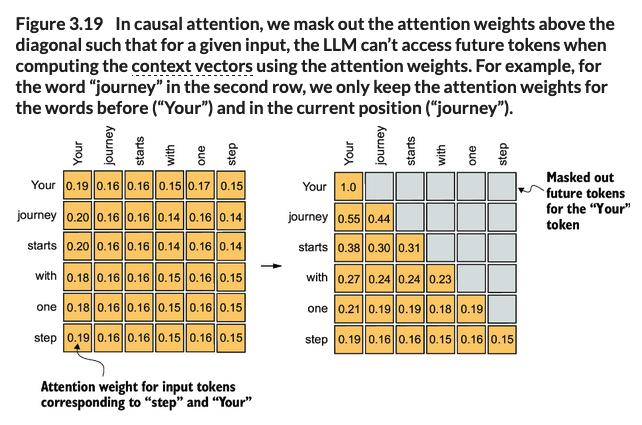[Image from LLM from Scratch Book (All right reserved)]

### 4.1. Applying a Causal Attention Mask

#### 4.1.1. Method 1

unnormalised attention scores ---> (Apply Softmax) ---> (Mask with 0's above diagonal) --> (Normalize Rows) --> Masked Attention Weights

In [31]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [32]:
## Values above diagonal are set to 0 via `tril`

context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [33]:
masked_attn_weights = attn_weights * mask_simple
print(masked_attn_weights)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [34]:
row_sums = masked_attn_weights.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_attn_weights / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


##### 4.1.1. Mathematical Working

When mask followed by normalisation is applied after computing attention score with future tokens, it might initially appear that information from future token could still influence as they are part of attenion score computation, but this not the case.

Suppose we have 3 tokens, and we are interested in causal self attention computation. Let's compute updated context for 2nd token

$$ q_1, q_2, q_3 $$ 
$$ k_1, k_2, k_3 $$

1. Attention Score

   * $q_2 * k_1$, $q_2 * k_2$, $q_2 * k_3$, 

2. Attention Weight [Before Masking]

   * Softmax
     * Numerator: $e^{q_2*k_i}$
  
     * Denominator: $\sum_{1}^{i=3} e^{q_2 * k_i}$

   * Attention Weight
     * $\frac{e^{q_2*k_1}}{\sum_{1}^{i=3} e^{q_2 * k_i}}$, $\frac{e^{q_2*k_2}}{\sum_{1}^{i=3} e^{q_2 * k_i}}$, $\frac{e^{q_2*k_3}}{\sum_{1}^{i=3} e^{q_2 * k_i}}$

3. Set last value of Attention Weight to 0

   * $\frac{e^{q_2*k_1}}{\sum_{1}^{i=3} e^{q_2 * k_i}}$, $\frac{e^{q_2*k_2}}{\sum_{1}^{i=3} e^{q_2 * k_i}}$, 0 

4. Normalise Attention Weight

   * Sum Value

     * $\frac{e^{q_2*k_1} + e^{q_2*k_2}}{\sum_{1}^{i=3} e^{q_2 * k_i}}$

   * Normalisation of Attention Weight

     * Denominator of attention weight for 1st token will cancel denominator of Sum value above, resulting

     * $\frac{e^{q_2*k_1}}{\sum_{1}^{i=2} e^{q_2 * k_i}}$, $\frac{e^{q_2*k_2}}{\sum_{1}^{i=2} e^{q_2 * k_i}}$, 0 


Above proofs shows there's no information leakage



#### 4.1.1. Method 2

A efficient way to obtain masked attention weight is to set attention score with -ve infinity before softmax operation

unnormalised attention scores ---> (Mask by -inf above diagonal) -->  unnormalised masked attention scores --> (Normalize Rows Via SoftMax) --> Masked Attention Weights

In [35]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [36]:
attn_weights = torch.softmax(masked / keys.shape[-1] ** 0.5, dim=-1)

In [37]:
masked

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)

In [38]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


### 4.2. Adding DropOut to Attention weights

Dropout is a technique used in DL where randomly selected hidden layers units are ignored during the training.
This method helps preventing overfitting by making sure model does not heavily depends on any specific set of hidden layer units.

> Note: It is only trained during training and is disabled afterward


DropOut is parameterised by $p$, (called dropout rate).

#### 4.2.1. Scaling Activation during Training

* When we drop units (i.e., set some activations to 0) during training, the total activation of a layer goes down.
  * But we don’t want the average activation of the layer to change between training and inference—because that would make the model behave inconsistently.

Let's illustrate why scaling is required

Dropout fraction is set to $p$

1. We have a neuron with activation value of : $a$

*During Training*, 

Expected value of activation of above neuorn

$$E[activation] = 0 * p + (1-p) * a = (1-p) * a$$

*During Inference*, 

Since DropOut is turned (Because we want reproducible Result), activation would be $a$.

Now, this is a problem as during training activation was: $(1-p) * a$

but if we scale activation by (1-p) during training the problem will be solved and we can use full network without dropout during inference!




In [39]:
drop = nn.Dropout(p=0.5)
x = torch.ones(10)
drop.train()
out = drop(x)
print(out) 

tensor([2., 2., 0., 0., 2., 2., 0., 0., 2., 0.])


In [41]:
torch.manual_seed(123)
print(drop(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


### 4.3. Implementing compact causal attention class

In [46]:
## simulating batch inputs
## inputs a set of sequence of 6 tokens projected in 3d space (6 * 3)
## torch.stack is adding another set of sequence into a tensor repr, leading to -> (2 * 6 * 3)

batch = torch.stack((inputs, inputs), dim=0)

In [ ]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):

        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # (batch, seq_len, d_out) * (batch, d_out, seq_len)
        # You’re multiplying a (seq_len × d_out) with a (d_out × seq_len) → results in a (num_tokens × num_tokens) matrix
        attn_scores = queries @ keys.transpose(1, 2) 

        attn_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ values
        return context_vec

In [53]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)

In [54]:
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])
